In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import glob
import json
import pickle as pkl
import ast
import os
from random import sample
import networkx as nx

from random import sample
import sklearn
import re
import string
import warnings
from bs4 import BeautifulSoup
import gensim
from gensim.models.phrases import Phrases
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from analysis_func.text_preproc import preproc_text
from analysis_func.topic_preproc import prepare_corp
from analysis_func.topic_model import topicmodel
from analysis_func.saveload_topicmodels import save_modelanddata, load_modelanddata
import datetime
import os
import time
import sys

from pandarallel import pandarallel
pandarallel.initialize()


INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
full_fdata = pd.read_csv("/data/shruti/ONR/small_data/facebook_linkpost_text.csv", header=0)
full_fdata = full_fdata.dropna(subset=['handle','message'])

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print("getting data")
# get random samples from each party of similar sizes
datafiles = glob.glob("/data/shruti/ONR/big_data/Twitter/*.csv")
plist = ['_BJP.csv', '_INC.csv']
pcount = defaultdict(list)
for d in datafiles:
    for p in plist:
        if p in d:
            pcount[p].append(d)
                
final_files = pcount
#final_files = defaultdict(list)
# for p in pcount:
#     try:
#         final_files[p] = sample(pcount[p], 1000)
#     except:
#         final_files[p] = sample(pcount[p], 430)
    
    
#read randomly sampled data into a dataframe
rowlist = []
for p in final_files.keys():
    party = p.replace("_", "").replace(".csv", "")
    for d in final_files[p]:
        with open(d, "r") as jsonfile:
            for line in jsonfile:
                job= json.loads(line)
                if "text" in job:
                    text = job['text']
                else:
                    text = None
                if "screen_name" in job:
                    sn = job['screen_name']
                else:
                    sn = None
                    
                if "lang" in job:
                    language = job['lang']
                else:
                    language = None
                    
                row = [sn, text, party, language]
                rowlist.append(row)

                
fulltdata = pd.DataFrame(rowlist, columns=['screen_name','text','party', 'language'])
fulltdata = fulltdata.dropna(subset=['text'])

getting data


In [4]:
fulltdata = fulltdata.dropna(subset=['text'])
fulltdata = fulltdata.dropna(subset=['screen_name'])


In [5]:
def remove_retweets(text):
    if "RT " in text:
    #if text.startswith("RT "):
        return 1

In [6]:
fulltdata['is_retweet'] = fulltdata['text'].parallel_apply(lambda x: remove_retweets(x))

In [7]:
fulltdata = fulltdata.loc[fulltdata['is_retweet']!=1.0]
len(fulltdata)

5468945

In [8]:
news_websites = pd.read_csv("../lite_data/Website_List.csv", header=0)
news_websites.head()

,UniqueID,Website_Name,Political_Leaning,Website_URL,Language,MobileSite,PrintMedia,TVMedia,OnlineMedia,FacebookReach,TwitterReach,InstagramReach,AlexaGlobalRank,AlexaIndiaRank,Parent_Company,Website_Registrar,Registered_On,Expires_On,TrafficContributingSubDomains
0,1.0,Aaj Tak,RIGHT_TO_RIGHTCENTRE,aajtak.intoday.in,Hindi,m.aajtak.in,N,Y,Y,26.2M,9.8M,3.7M,607.7K,98.2K,Living Media Group (TV Today Network Limited),MPS Infotecnics Limited,16/02/2005,16/02/2029,"{'m.aajtak.in': '93.83%', 'OTHER': '6.17%'}"
1,2.0,Dainik Jagran,RIGHT_TO_RIGHTCENTRE,jagran.com,Hindi,m.jagran.com,Y,N,Y,14.8M,1.1M,58.5K,1.7K,132,Jagran Prakashan Limited,"Network Solutions, LLC",17/01/1997,18/01/2030,"{'jagran.com': '70.51%', 'epaper.jagran.com': ..."
2,3.0,RVCJ News,NaN,rvcj.com,English,N,N,N,Y,14.5M,193.0K,2.5M,26.9K,3.8K,RVCJ Digital Media Private Limited,"NameCheap, Inc.",20/04/2007,20/04/2022,"{'rvcj.com': '99.04%', 'OTHER': '0.97%'}"
3,4.0,Dainik Bhaskar,RIGHT_TO_RIGHTCENTRE,bhaskar.com,Hindi,N,Y,N,Y,14.3M,1.0M,988.2K,1.3K,107,D B Corp Limited,PDR Ltd. d/b/a PublicDomainRegistry.com,17/04/1998,16/04/2029,"{'bhaskar.com': '72.22%', 'epaper.bhaskar.com'..."
4,5.0,Zee News,RIGHT_TO_RIGHTCENTRE,zeenews.india.com,English,N,N,Y,Y,11.4M,3.2M,1.8M,74.9K,7.6K,Essel Group,"GoDaddy.com, LLC",13/08/1997,30/05/2027,"{'cdn.zeenews.com': '53.01%', 'my.zeenews.com'..."


In [9]:
news_websites['TrafficContributingSubDomains'] = news_websites['TrafficContributingSubDomains'].fillna('{}')

In [10]:
import ast

news_websites['TrafficContributingSubDomains'] = news_websites['TrafficContributingSubDomains'].apply(ast.literal_eval)
    

In [11]:
all_splits = []
for idx, row in news_websites.iterrows():
    try:
        el = row['Website_URL'].split(".")
    except:
        el = []
        
    try:
        ml = row['MobileSite'].split()
    
    except:
        ml = []
        
    kl = []
    ks = row['TrafficContributingSubDomains'].keys()
    for k in ks:
        if k!= 'OTHER':
            kl = kl + k.split(".")
            
    fl = el + ml + kl
    all_splits = all_splits + fl
            


In [12]:
print(Counter(all_splits))

Counter({'com': 480, 'N': 100, 'in': 85, 'epaper': 39, 'indiatimes': 24, 'm': 22, 'hindi': 20, 'ndtv': 18, 'images': 16, 'news18': 16, 'punjabkesari': 16, 'webdunia': 16, 'indianexpress': 14, 'jagran': 13, 'oneindia': 13, 'thehindu': 12, 'hindustantimes': 11, 'mathrubhumi': 11, 'dinamalar': 10, 'manoramaonline': 10, 'dailyhunt': 10, 'amarujala': 9, 'net': 9, 'bhaskar': 8, 'patrika': 8, 'moneycontrol': 8, 'business-standard': 8, 'greatandhra': 8, 'india': 7, 'cdn': 7, 'timesnownews': 7, 'scoopwhoop': 7, 'eenadu': 7, 'thewire': 7, 'english': 6, 'timesofindia': 6, 'lokmat': 6, 'anandabazar': 6, 'mid-day': 6, 'scroll': 6, 'siasat': 6, 'andhrajyothy': 6, 'newsnation': 6, 'thehindubusinessline': 6, 'zeenews': 5, 'bbc': 5, 'telugu': 5, 'jansatta': 5, 'firstpost': 5, 'livehindustan': 5, 'republicworld': 5, 'telanganatoday': 5, 'telegraphindia': 5, 'tribuneindia': 5, 'newstracklive': 5, 'indiatvnews': 4, 'malayalam': 4, 'tamil': 4, 'thequint': 4, 'media': 4, 'financialexpress': 4, 'pinkvilla': 

In [13]:
whitelist = ['com', 'N', 'net', 'in', 'm', 'india', 'english', 'malayalam', 'tamil', 'media', 'bengali', 
             'kannada', 'archive', 'gujarati', 'api', 'nic', 'brut', 'my', 'auth', 'bangla', 'punjabi', 'up',
             'mp', 'assam', 'odia', 'punjabi', 'tai', 'dev', 'uat', 'auto', 'fr', 'nari', 'step', 'temple', 
             'hindi', 'satyagrah', 'c', 's', 'lit', 'science']

In [14]:
all_handles = list(set(full_fdata['handle'].tolist()))
check_handle = pd.DataFrame()
check_handle['handle'] = all_handles

In [15]:
domain_shorts = [d for d in Counter(all_splits).keys() if d not in whitelist] + ['toi']

In [16]:
def checkhandleshort(text):
    for d in domain_shorts:
        if d in text.lower():
            return d
        
    return 0
check_handle['is_newshshort'] = check_handle['handle'].parallel_apply(lambda x: checkhandleshort(x))

In [17]:
print(Counter(check_handle['is_newshshort'].tolist()))

Counter({0: 67632, 'news': 1825, 'org': 1093, 'tv': 796, 'ems': 522, 'sso': 516, 'amp': 411, 'tech': 278, 'food': 209, 'support': 199, 'ians': 185, 'bharat': 169, 'social': 163, 'travel': 162, 'daily': 154, 'sports': 135, 'fit': 134, 'shop': 126, 's4': 125, 'blog': 123, 'children': 99, 'punjab': 93, 'patrika': 91, 'business': 83, 'web': 83, 'digital': 74, 'doctor': 63, 'toi': 58, 'cinema': 55, 'astro': 52, 'khabar': 52, 'money': 51, 'himachal': 48, 'mobi': 46, 'direct': 44, 'special': 44, 'haryana': 43, 'wap': 38, 'marathi': 36, 'jobs': 35, 'telugu': 35, 'gallery': 34, 'movies': 33, 'events': 33, 'ywc': 32, 'urdu': 24, 'data': 23, 'cloud': 23, 'ndtv': 22, 'account': 21, 'jagran': 20, 'thehindu': 19, 'beta': 19, 'user': 18, 'careers': 17, 'lokmat': 17, 's3': 17, 'regional': 16, 'mail': 16, 'image': 15, 'mathrubhumi': 15, 'bhaskar': 15, 'cms': 14, 'frontline': 12, 'oneindia': 11, 'bbc': 10, 'img': 10, 'aajtak': 10, 'amarujala': 9, 'zeenews': 9, 'eenadu': 8, 'indiatoday': 8, 'archives': 8

In [18]:
check_handle.loc[check_handle['is_newshshort']=='toi']

,handle,is_newshshort
6524,aristoindia,toi
6921,toinagpur,toi
8215,Mytriptoindiadelhi,toi
8219,Chandigarh.TOI,toi
12766,BrestOilReundar,toi
15631,nirvanatourstoindia,toi
15717,toidocsachonline,toi
17312,aeyautoimport.car,toi
17983,RudySotoIDUSA,toi
18842,TOINoida,toi


In [19]:
valid_handles = check_handle.loc[check_handle['is_newshshort']==0]['handle'].tolist()
print(len(valid_handles))

67632


In [20]:
tframe = fulltdata[['screen_name','party','text']]
fframe = full_fdata.loc[full_fdata['handle'].isin(valid_handles)][['handle','message']]

tframe = tframe.rename(columns={'screen_name':'handle', 'text':'message'})
fframe['party'] = 'facebook_group'

tframe['handle'] = tframe['handle'].apply(lambda x: x + "_twitter")
fframe['handle'] = fframe['handle'].apply(lambda x: x + "_facebook")


In [21]:
frame = pd.concat([tframe, fframe])

In [22]:
frame.head()

,handle,party,message
100,Karan4BJP_twitter,BJP,@DivyaGuptabjp @vdsharmabjp @vaibhavpawarmp सभ...
104,Karan4BJP_twitter,BJP,@JPNadda @ombirlakota आपके follow back की प्रत...
105,Karan4BJP_twitter,BJP,How's it's ⁉️😅\nकैसी रही मित्रों..... https://...
106,Karan4BJP_twitter,BJP,@Twitter Tonight you're eating followers in yo...
107,Karan4BJP_twitter,BJP,@SuhasBhagatBJP @TwitterIndia भाईसाहब सभी के उ...


In [23]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)




remove_urls = lambda x: re.sub("http(.+)?(\W|$)", ' ', x)
remove_RT = lambda x: x.replace("RT ", "")
remove_mentions = lambda x: re.sub("@\S+", '', x)
remove_hashtags = lambda x: re.sub("#\S+", '', x)
remove_digits = lambda x: re.sub("\d+", "", x)
remove_punct = lambda x: re.sub("!|\||\%|\.|\-|\/|:|…|,|\?|।+|'|⁉|\*|‘|’|\"|\(|\)+", "", x)
remove_emojis = lambda x: emoji_pattern.sub("", x)
normalize_spaces = lambda x: re.sub("[\n\r\t ]+", ' ', x)


In [24]:
remove_noise = lambda x:normalize_spaces(
                                remove_emojis(
                                    remove_punct(
                                        remove_digits(
                                            remove_hashtags(
                                                remove_mentions(
                                                    remove_punct(
                                                        remove_urls(x.lower()))))))))


In [25]:
frame['clean_text'] = frame['message'].parallel_apply(lambda x: remove_noise(x) if len(x) >15 else '0')

In [26]:
frame.sample(5)

,handle,party,message,clean_text
2263838,kislay_official_twitter,BJP,झारखंड के नवनियुक्त राज्यपाल आदरणीय श्री रमेश ...,झारखंड के नवनियुक्त राज्यपाल आदरणीय श्री रमेश ...
10585600,SandeepkumarINC_twitter,INC,अ.भ. कांग्रेस कमेटी के राष्ट्रीय महासचिव व गोव...,अभ कांग्रेस कमेटी के राष्ट्रीय महासचिव व गोवा ...
14024942,AnilChopraINC_twitter,INC,सभी प्रदेशवासियों को सूर्य उपासना व लोक आस्था ...,सभी प्रदेशवासियों को सूर्य उपासना व लोक आस्था ...
12597098,Chittillappilly_twitter,INC,#BeautyOfIndia\n#India https://t.co/RPMINUPfbX,
1962542,ashu_k7_twitter,BJP,@karanjohar I never knew you have the power to...,i never knew you have the power to bless or c...


In [27]:
print(len(frame))
frame = frame.loc[frame['clean_text']!='0']
print(len(frame))

8314017
8265844


In [28]:
frame.to_csv("/data/shruti/ONR/small_data/Fb_twitter_joinedtext_nonews.csv")

In [29]:
frame['textlen'] = frame['clean_text'].parallel_apply(lambda x: len(x.split(" ")))

<AxesSubplot:>

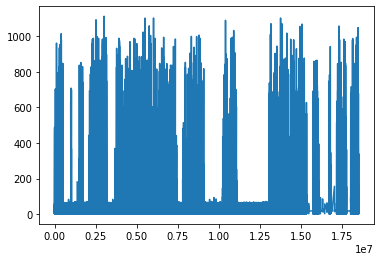

In [30]:
frame['textlen'].plot()

In [31]:
frame = frame.loc[frame['textlen']>9]
len(frame)

5899027

In [32]:
frame.sample(5)

,handle,party,message,clean_text,textlen
7255031,Advrsrajeev_twitter,BJP,Hon'ble PM @narendramodi Ji visited Gurudwara ...,honble pm ji visited gurudwara sis ganj sahib ...,24
2323333,kishanreddybjp_twitter,BJP,Nothing to worry.\nHave spoken to the local ad...,nothing to worry have spoken to the local admi...,33
7487,htlucknow_facebook,facebook_group,The Congress is looking to make a comeback in ...,the congress is looking to make a comeback in ...,16
7641718,ManishMib_twitter,INC,@IYC रोटी का निवाला तोड़ते हुए इतना ध्यान \nजर...,रोटी का निवाला तोड़ते हुए इतना ध्यान जरूर कर ...,24
15212459,Rajeevbhartiyaindia_facebook,facebook_group,राहुल गाँधी/काँग्रेस की तरफ़ से इसपर कुछ टिप्पण...,राहुल गाँधीकाँग्रेस की तरफ़ से इसपर कुछ टिप्पणी...,53


<AxesSubplot:>

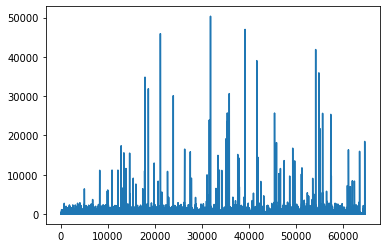

In [51]:
n_contrib = frame.groupby('handle').size().reset_index()
n_contrib[0].plot()

In [33]:
frame.to_csv("/data/shruti/ONR/small_data/Fb_twitter_joinedtext_nonews_morethan10words.csv")

<AxesSubplot:ylabel='Frequency'>

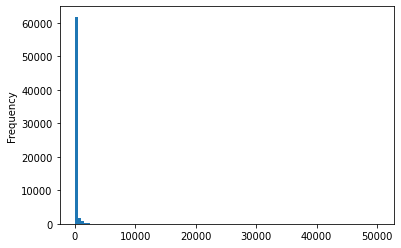

In [52]:
n_contrib[0].plot(kind='hist', bins=100)

In [54]:
n_contrib.sort_values(by=0).tail(50)

,handle,0
12152,GloriousUP_facebook,11161
33726,VoiceOfIn_facebook,11167
57413,samajwadicyclepage_facebook,11170
10905,FanofINC_facebook,11173
46716,indiacom_facebook,11562
13868,IETamil_facebook,11570
37952,banglahuntofficial_facebook,11665
51297,mint.live_facebook,11737
19859,MirrorNow_facebook,12960
49753,livelawindia_facebook,13505


In [55]:
valid_handles = n_contrib.loc[(n_contrib[0]>4)&(n_contrib[0]<15000)]['handle'].tolist()
print(len(valid_handles))

18690


In [56]:
frame = frame.loc[frame['handle'].isin(valid_handles)]
len(frame)

4962991

In [58]:
frame.sample(5)

,handle,party,message,clean_text,textlen
1448984,abvpodisha_twitter,BJP,"Because God could not be everywhere, he made s...",because god could not be everywhere he made su...,38
2975182,TIME8English_facebook,facebook_group,এদিন দুদিন কৈ বছৰত ২২ হাজাৰ বিঘা চৰকাৰী ভূমি দ...,এদিন দুদিন কৈ বছৰত হাজাৰ বিঘা চৰকাৰী ভূমি দখল ...,12
2357358,ShivpalSingYadav_facebook,facebook_group,मथुरा: यमुना एक्सप्रेसवे पर विमान की आपातकालीन...,मथुरा यमुना एक्सप्रेसवे पर विमान की आपातकालीन ...,11
5097177,SushilModi_twitter,BJP,1/3-.....यानी भारत से करीब एक महीने पहले टीकाक...,यानी भारत से करीब एक महीने पहले टीकाकरण अभियान...,24
11341508,SantoshSkamble5_twitter,INC,प्रधानमंत्री ने पिछले तीन वर्षों में तीन बार 1...,प्रधानमंत्री ने पिछले तीन वर्षों में तीन बार ल...,51


In [59]:
corpus = frame['clean_text'].tolist()
splitcorpus = [c.strip().split(" ") for c in corpus]
splitcorpus[0]

['आपके', 'follow', 'back', 'की', 'प्रतीक्षा', 'है', 'भाजपा', 'कार्यकर्ता']

In [60]:
phrases = Phrases(splitcorpus, min_count=10, threshold=0.1)
tokes = [phrases[t] for t in splitcorpus]

In [64]:
tokes[22]

['इंदौर_पुलिस',
 'ने',
 'मोमिन',
 'नामक',
 'ऐसे',
 'बांग्लादेशी',
 'को_गिरफ्तार',
 'किया_है',
 'जिसने',
 'से_ज्यादा',
 'लड़कियों_को',
 'सेक्स_रैकेट',
 'धकेल_उनके',
 'जीवन_को',
 'तबाह_किया',
 'मोमिन',
 'ने_शादी',
 'की',
 'साथ_ही',
 'गर्लफ्रेंड',
 'भी_बनाई',
 'इसी',
 'संक्रमण_को',
 'देश_से',
 'बाहर',
 'फेंकने_के',
 'लिए',
 'की_जरूरत',
 'है']

In [65]:
4962991*0.0001

496.2991

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc

cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy,max_df=0.2, min_df=0.000005)  

In [67]:
X = cv.fit(tokes)

/home/phadke/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [69]:
X = cv.fit_transform(tokes)

In [70]:
X.shape

(4962991, 429412)

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [72]:
pca = PCA(n_components=200)

In [74]:
Y =X.toarray()

MemoryError: Unable to allocate 15.5 TiB for an array with shape (4962991, 429412) and data type int64

In [73]:
pMat = pca.fit_transform(X)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.